# Clasificacion de Vinos

Adrián de Lucas Gómez y Andrés Ruiz Bartolomé

In [14]:
import numpy as np

import checkNNGradients as checkNNG

import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.sparse.construct import random
import scipy.optimize as opt

import sklearn.model_selection as ms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns

from pandas.io.parsers import read_csv
import pandas as pd

En este proyecto vamos a utilizar varios métodos vistos en **Aprendizaje Automático** para intentar predecir si cierto vino vale la pena o no, basándonos en parámetros fisio-químicos (densidad, alcohol, acidos cítricos, ph...). Para ello vamos a usar el datatset [Red Wine Quality](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009).

Vamos a usar: Regresión Logística, Redes Neuronales, _Suport Vector Machines_ y Bosques Aleatorios.

## Visualizacion de los datos
Para empezar, vamos a cargar el archivo con los datos de los vinos y a mirar con que vamos a trabajar

In [15]:
wines = read_csv('winequality-red.csv')
print(wines.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [16]:
print(wines.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [17]:
print(wines.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

Aqui podemos ver un mapa que indica la correlacion entre los parámetros del set de datos. Cuanto más morado, mas correlacion hay, y cuanto mas naranja, menos correlacion. Podemos ver que el valor que más afecta a la calidad es el alcohol.

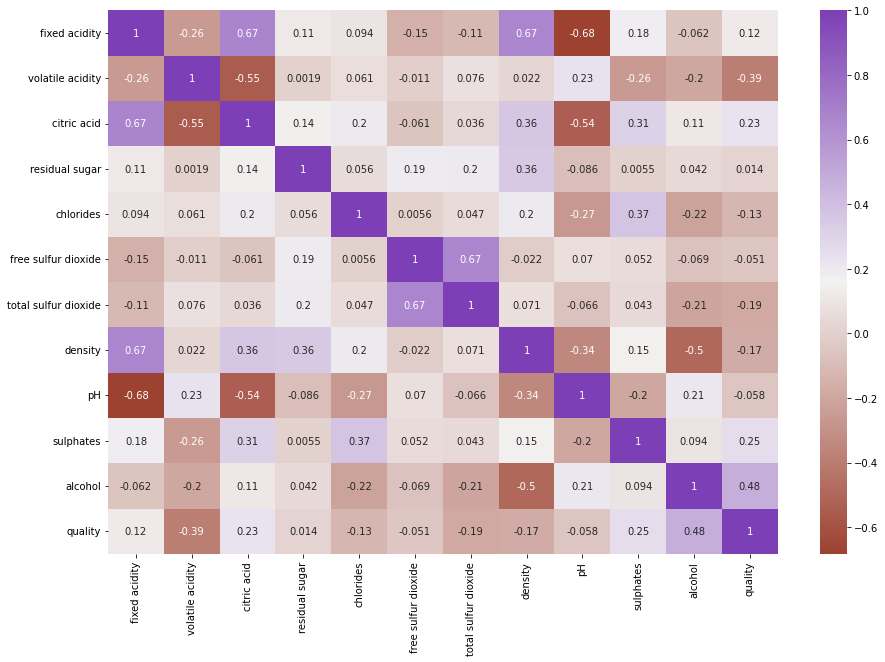

In [18]:
corr = wines.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
            cmap=sns.diverging_palette(18, 282, s=70, l=40, as_cmap=True))
plt.show()

Estas graficas muestran la distribucion de los 1599 casos de prueba en los diferentes parámetros

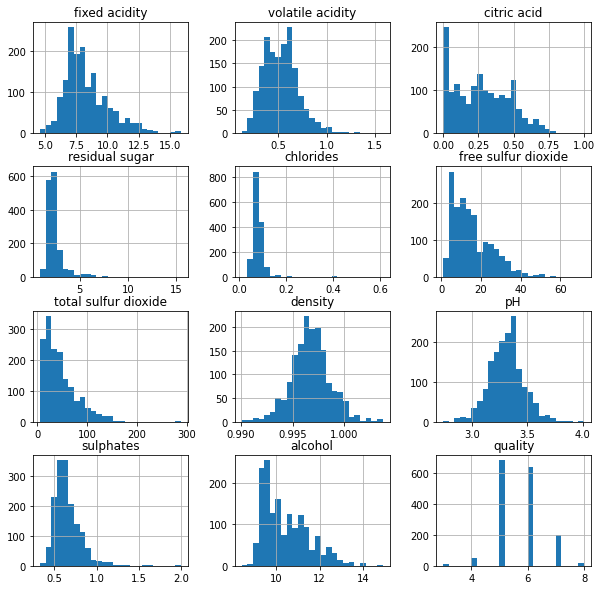

In [19]:
wines.hist(bins=25,figsize=(10,10))
plt.show()

## Tratamiento de los parámetros

Lo primero que deberemos de hacer para empezar a trabajar es agrupar los valores de calidad del vino ya que queremos dividirlo en 2 grupos pero tenemos calificaciones desde 2 hasta 8.

Una vez hemos agrupado los distintos valores en 0 (vino poco recomendable) y 1 (vino que esta bien) tendremos que contabilizar para saber la proporcion que hat de cada uno.

Luego procederemos a distribuir el dataSet en 3 conjuntos: entrenamiento, validación y prueba. Una vez troceado se normalizan los datos.

**NOTA:** Podremos descartar algunos atributos del vino que no sean muy importante en relación a su calidad evitando así ruido innecesario y mejorando un poco la precision. Para saber cuales se pueden quitar en el apartado del RANDOM FOREST se puede ver. 

In [20]:
bins = (2, 5.5, 9)  #Consideramos que cualquier vino con un 2,3,4 o 5 es "mediocre" y los 6,7,8,9 son buenos
group_names = [0,1] #0 malos /  1 buenos
wines['quality'] = pd.cut(wines['quality'], bins = bins, labels = group_names)

#OPCIONAL Quitamos los parametros menos relevantes evitando ruido y mejorando la precision
# X = X.drop('residual sugar', axis = 1)
# X = X.drop('fixed acidity', axis = 1)
# X = X.drop('free sulfur dioxide', axis = 1)
# X = X.drop('citric acid', axis = 1)
#################################################################################

#Quitamos la columna de valores (que es lo que queremos determinar nosotros) y las etiquetas
X_raw = wines.drop('quality', axis = 1)
X = X_raw.values

y = wines['quality']
y = y.astype(int).values

counts = wines['quality'].value_counts()

nbad = counts[0]
ngood = counts[1]

print(f"Numero de vinos: \"malos\" {nbad} y buenos: {ngood}")

########################### Troceo de los casos ################################

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = ms.train_test_split(X_train, y_train, test_size=0.25, random_state=1)

#Distribucion de los tamaños para loc conjuntos de entrenamiento, validacion y prueba
print(f"Tamaños de los conjuntos: entrenamiento: {len(X_train)}, test: {len(X_test)} y validacion: {len(X_valid)}")

#Por ultimo normalizamos los datos
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_valid = sc.fit_transform(X_valid)

Numero de vinos: "malos" 855 y buenos: 744
Tamaños de los conjuntos: entrenamiento: 959, test: 320 y validacion: 320


# Regresión logística

Para utilizar regresion logistica deberemos de usar los metodos de coste y gradiente usado en las prácticas. En esta ocasion el sigmoide usado es el de la libreria y lleva el nombre de **expit**.

Para comenzar deberemos de añadir una columna de uno a los datos de entrada para poder usar vectorización. Usaremos la función **opt.fmin_tnc** para tratar de buscar la configuracion con menos coste e iremos probando con diferentes valores de regularización hasta dar con el mejor.

Buscaremos la configuración que arroje la mejor precision con los datos de validación y despues probaremos que tal se ha ajustado a los datos del conjunto de test.

In [21]:
def costeRegularizado(theta, X, Y, lambo):
	m = np.shape(X)[0]
	return coste(theta, X, Y ) + lambo * np.sum(theta**2)/(2*m)

def coste(theta, X, Y):

	H = expit(np.matmul(X, theta))

	cost = (-1/(len(X))) * (np.dot(Y, np.log(H+ 0.00000001)) +
							np.dot((1-Y), np.log(1-H + 0.00000001)))

	return cost

def gradiente(theta,XT, Y):
	H = expit(np.matmul(XT, theta))

	grad = (1/len(Y)) * np.matmul(XT.T, H - Y)
	return grad

def gradienteRegularizado(theta,XT, Y, lambo):
	grad = (gradiente(theta,XT, Y))
	a = grad[0]
	reg = lambo*theta / len(Y)
	reg[0] = a
	return grad + reg

In [22]:
def evaluaLogistica(X,Y,theta):
	b = expit( np.dot(X,theta))>=0.5
	correctos = np.sum((expit( np.dot(X,theta))>=0.5)==Y)
	return correctos / np.shape(X)[0]

In [23]:
################# LOGISTIC REGRESION ###################

Rs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

m = np.shape(X_train)[0]
X_train_s = np.hstack([np.ones([m, 1]),X_train])

m = np.shape(X_valid)[0]
X_valid_s = np.hstack([np.ones([m, 1]),X_valid])

m = np.shape(X_test)[0]
X_test_s = np.hstack([np.ones([m, 1]),X_test])

theta = np.zeros(np.shape(X_train_s)[1])

r_opt = 0
maxAccuracy = 0

for r in Rs:
    result = opt.fmin_tnc(
        func = costeRegularizado, x0 = theta, fprime = gradienteRegularizado,
        args = (X_train_s, y_train, r))
    theta_opt = result[0]

    accuracy = evaluaLogistica(X_valid_s, y_valid, theta_opt)

    if accuracy > maxAccuracy:
        r_opt = r
        maxAccuracy = accuracy

print(f"Maxima tasa de acierto en validación: {maxAccuracy*100}%")

# Resultados con los datos no vistos

accuracy = evaluaLogistica(X_test_s, y_test, theta_opt)
print(f"Maxima tasa de acierto con datos de test: {accuracy*100}%")
    

Maxima tasa de acierto en validación: 72.5%
Maxima tasa de acierto con datos de test: 75.3125%


También hemos decidido comparar nuestra versión con la de la libreria para ver como varia una de otra teniendo los mismos datos para entrenar, validar y comprobar.

In [26]:
################# LOGISTIC REGRESION DE LIBRERIA ###################

#Busqueda de la mejor configuracion de C

Cs = [ 0.03, 0.1, 0.3, 1, 3, 10, 30]
bestC = 0
maxAccuracy = 0
for Ci in Cs:     
    logReg = LogisticRegression(random_state=1, solver='lbfgs', C=Ci)
    logReg.fit(X_train, y_train)
    pred_sgd = logReg.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred_sgd)

    if accuracy > maxAccuracy:
        maxAccuracy = accuracy
        bestC = Ci

print(f"Maxima tasa de acierto en validación: {maxAccuracy*100}%\n")   

# Resultados con los datos no vistos

logReg = LogisticRegression(random_state=1, solver='lbfgs', C=bestC)
logReg.fit(X_valid, y_valid)
pred_sgd = logReg.predict(X_test)

print(f"Resumen de regresion logistica con datos de test:")
print(classification_report(y_test, pred_sgd))

Maxima tasa de acierto en validación: 72.5%

Resumen de regresion logistica con datos de test:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       154
           1       0.75      0.73      0.74       166

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



# Redes Neuronales

Como en las practicas deberemos de hacer uso de las funciones de coste, propagación hacia delante y hacia atrás.

En este caso deberemos de encontrar la mejor configuracion para el parámetro de regularización y el número de neuronas ocultas que mejoran la precisión de esta red neuronal.

Una vez tengamos la mejor configuracion que da la mayor tasa de aciertos la mostraremos junto a la matriz de confusion la cual nos indicará adema de los aciertos los falsos positivos y falsos negativos.

In [27]:
def costeNN(X, Y, theta1, theta2):

    a1, a2, H = redNeuronalPaLante(X, theta1,theta2) #Haces la pasada por la red neuronal

    #Queda mas claro dividido por partes
    op1= -1/(len(X))    
    op2 = Y.dot(np.log(H))
    op3 = (1-Y).dot(np.log(1-H))

    cost = op1 * np.sum(op2 + op3)
    return cost

def costeNNReg(X, Y, theta1, theta2, lambo):
    costeN = costeNN(X, Y, theta1, theta2)
    costeR = costeN + (lambo/(2*len(X)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:]))))
    return costeR

def redNeuronalPaLante(X, theta1, theta2):
    
    xSize = X.shape[0]
    # Capa de entrada
    a1 = np.hstack([np.ones((xSize,1)), X])    
    # Capa oculta    
    z2 = theta1.dot(a1.T)
    a2 = np.hstack([np.ones((xSize,1)), expit(z2.T)])
    # Capa de salida
    z3 = np.dot(a2, theta2.T) 
    a3 = expit(z3) #Es la hipotesis

    return (a1, a2, a3)

def redNeuronalPatras(params_rn, n_input, n_hidden, n_labels, X, y, lambdita):
    theta1 = np.reshape(params_rn[:n_hidden * (n_input+1)], (n_hidden, (n_input+1)))
    theta2 = np.reshape(params_rn[n_hidden * (n_input+1):], (n_labels, (n_hidden+1)))
    
    m = len(X)
    A1, A2, H = redNeuronalPaLante(X, theta1, theta2)

    Delta1 = np.zeros_like(theta1)
    Delta2 = np.zeros_like(theta2)

    for t in range(m):
        a1t = A1[t, :]
        a2t = A2[t, :]
        ht = H[t, :]
        yt = y[t]

        d3t = ht - yt
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t))

        Delta1 = Delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        Delta2 = Delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])

    
    #Gradientes
    G1= Delta1 / m
    G2 = Delta2 / m

    #Lambdas
    lambo1 = lambdita * theta1 / m
    lambo2 = lambdita * theta2 / m

    lambo1[:, 0] = 0
    lambo2[:, 0] = 0

    G1 += lambo1
    G2 += lambo2

    gradiente = np.concatenate((np.ravel(G1), np.ravel(G2)))

    #Coste
    coste = costeNNReg(X, y, theta1, theta2, lambdita)

    return coste, gradiente

def randomWeights(L_ini, L_out, E_ini):
    return np.random.random((L_out, L_ini + 1)) * (2*E_ini) - E_ini


In [29]:
################# REDES NEURONALES ###################

input_size = np.shape(X)[1]
out_size = 2 #bueno o malo
num_hidden = np.arange(5,50,5)

num_labels = 2

lambdas = np.arange(0,2,0.05)

record = 0
bestL = 0
bestHid = 0
bestGuess = 0

for hid in num_hidden:
    for l in lambdas:

        #Elejimos valores aleatorios para las thetas
        theta1 = randomWeights(input_size, hid, 0.12)
        theta2 = randomWeights(hid, out_size, 0.12)
        #Los guardamos para probar con ellos
        params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
        
        num_Iterations = 100     #Vueltas dadas para tratar de optimizar
        optimizeResult = opt.minimize(
            fun=redNeuronalPatras,
            x0=params_rn,
            args=(input_size, hid, num_labels, X_train, y_train, l),
            method='TNC',
            jac=True,
            options={'maxiter': num_Iterations})

        H =  redNeuronalPaLante(X_valid, theta1, theta2)[2]

        predValues = np.zeros(np.shape(H)[0])

        i = 0

        for v in H:
            if(v[0]>v[1]):
                predValues[i] = 0
            else:
                predValues[i] = 1
            i += 1

        nn_matrix = confusion_matrix(y_valid, predValues)
        # print("Confusion matrix:")
        # print(nn_matrix)

        porcentaje = ((nn_matrix[0][0] + nn_matrix[1][1]) / np.shape(H)[0]) * 100

        if porcentaje > record:
            record = porcentaje
            bestL = l
            bestHid = hid
            bestGuess = predValues

        #print(f"Precision de la red con lambda {l} y {hid} neuronas ocultas")
        #print(f"{porcentaje}%\n")

print(f"La mejor configuracion de la red fue con lambda = {bestL} y {bestHid} neuronas ocultas, con un porcentaje de {record}%")

nn_matrix = confusion_matrix(y_valid, bestGuess)
print("Matriz de confusion:")
print(nn_matrix)


La mejor configuracion de la red fue con lambda = 0.9500000000000001 y 5 neuronas ocultas, con un porcentaje de 63.74999999999999%
Matriz de confusion:
[[ 61  98]
 [ 18 143]]


# Support Vector Machines
Cuando se hace uso de las Support Vector Machines tenemos que tratar de buscar la mejor configuración para 2 parámetros: C y sigma. Ambos son parámetros de regulacion con los cuales se ajusta el comportamiento con el objetivo de adecuarlo mas o menos a los datos que le damos, controlando así el sobreajuste.

Una vez hemos dado con la configuracion que arroja mejor fiabilidad deberemos de probarlo con los ejemplos de prueba (datos que no se han usado para entrenar)

In [ ]:
################# SVM ###########################

Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

bestAcc = 0
bestC = 0
bestSig = 0

for c in Cs :
    for s in sigmas:

        svc = SVC(kernel='rbf', C=c, gamma=1/(2 * s**2))
        svc.fit(X_train, y_train)
        pred_svc = svc.predict(X_valid)
        accuracy = accuracy_score(y_valid, pred_svc)
        if bestAcc < accuracy:
            bestAcc = accuracy
            bestC = c
            bestSig = s

svc = SVC(kernel='rbf', C=bestC, gamma=1/(2 * bestSig**2))
svc.fit(X_valid, y_valid)

pred_svc = svc.predict(X_test)
print(f"Resumen de SVM con C = {bestC} y Sigma = {bestSig}\n")
print(classification_report(y_test, pred_svc))


Resumen de SVM con C = 1 y Sigma = 1

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       154
           1       0.75      0.81      0.78       166

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



# Random Forest
Aparte de los modelos vistos en clase, vimos que mucha gente usaba Bosques Aleatorios para este tipo de ejercicios (de clasificación), así que decidimos probarlo.

Es un metaestimador que hace uso de varios árboles de decisión a varios niveles en el conjunto de datos. Para mejorar la precisión predictiva y controlar el sobreajuste se hace la media con los resultados dados por esos arboles. Esto es así porque los arboles de decisión por si solos tienden rápidamente al sobreajuste.

Como en los otros clasificadores deberemos de encontrar la configuracion que maximiza el numero de aciertos o lo que es lo mismo, minimizar costes.

Hay muchos parámetros posibles para configurar un bosque aleatorio pero en esta ocasion hemos decidido ver que numero de arboles de decisión es el óptimo.


In [ ]:
################# RANDOM FOREST CLASIFICATION ###############

num_Estimadores = np.linspace(50, 150, 10)# numero de arboles en el bosque

maxAccuracy = 0
bestEst = 0

for est in num_Estimadores:
    randForest = RandomForestClassifier(random_state=0,)
    randForest.fit(X_train, y_train)
    pred_rfc = randForest.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred_rfc)

    if(accuracy > maxAccuracy):
        bestEst = est
        maxAccuracy = accuracy

pred_rfc = randForest.predict(X_test)

print(f"Resumen de Random Forest con numero de arboles = {bestEst}\n")
print(classification_report(y_test, pred_rfc))


Resumen de Random Forest con numero de arboles = 50.0

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       154
           1       0.81      0.82      0.81       166

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



# Importancia de los parámetros

Gracias al Random forest podemos ver la influencia que tiene cada parámetro de un vino en relacion a su calidad. Este dato coincide con los del mapa de calor, siendo una vez más el alcohol el más influyente.

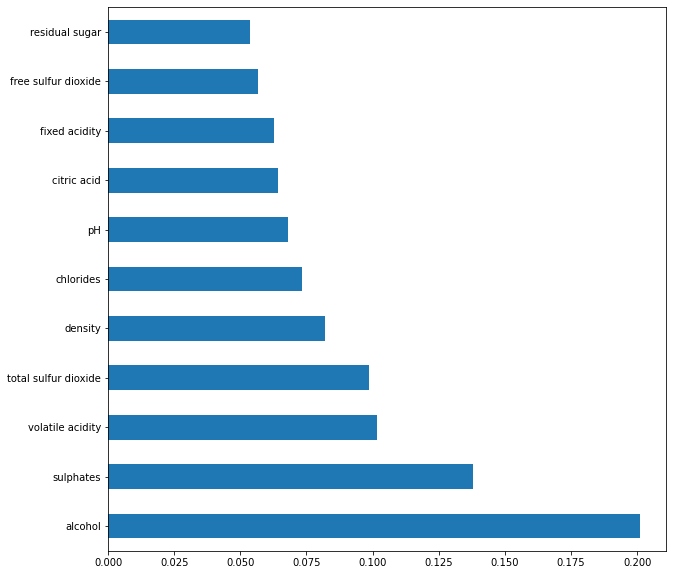

In [ ]:
####### Utilidad de los atributos #######
param_importances = pd.Series(randForest.feature_importances_, index= X_raw.columns)
param_importances.nlargest(25).plot(kind='barh',figsize=(10,10))
plt.show()

## Conclusiones

Como era de esperar nos ha resultado más cómodo usar las librerías que nuestros propios métodos. Sin embargo, estamos satisfechos con su desempeño (sobre todo con la regresión logística, en la que conseguimos un mayor porcentaje de aciertos que la funcion de librería)

| Metodo | Porcentaje de aciertos |
| ----------- | ----------- |
| Bosques Aletorios | 81% | 
| Regresión Logística (propia) | 75,3% |
| Regresión Logística (libreria) | 73% |
| SVMs | 73% | 
| Redes Neuronales | 63,8% |